In [142]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [143]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

### Grating as Sample

In [80]:

p = 2e-6
L = 8
Ls = 3.6

mt = 5



polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9



lam = np.array([5e-10])
plam = np.array([1])



lam, plam = polyspectrum.copy()


x0 = np.array([0])


Nbc = 5e28*4.149e-15



h1 = h2 = np.pi/2 / (Nbc*lam[np.argmax(plam)])

phi1 = phi2 =  Nbc*lam * h1 



slitx = 200e-6

xbin = 1e-6
ybin = 1e-6

res = 100e-6
L1 = 4


dsample = np.linspace(0.25,4.25,120) * p**2/lam[np.argmax(plam)]


ps_vals = np.linspace(0.1,3,52) * p





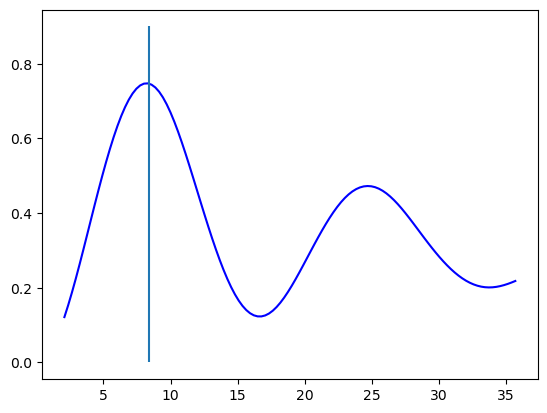

0.20235800743103027 seconds


In [81]:
t0 = time()



G1sd = {"p":p, "L1": np.array([L1]), "phi": phi1, "mt":mt, "spectrum_spacing": 1}
G1sd["L2"] = dsample


G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1}


G2sd["L2"] = np.array([L]) - G2sd["L1"]

simaptsnosample = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}

siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":L,"d": dsample  ,"mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
           "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res  }

simnosample = PGMI(simaptsnosample,siminit)

simnosample.propagate_to("G1")
simnosample.propagate_to("G2")

simnosample.generate_after("G2")



plt.plot(dsample*1e3,simnosample.contrast, "b-")
plt.vlines(p**2/lam[np.argmax(plam)] * 1e3, 0,0.9)
plt.show()



contnosamplepoly = np.squeeze(simnosample.contrast)

# contnosample5A= np.squeeze(simnosample.contrast)



print(time() - t0, "seconds")

In [64]:
t0 = time()

#contsamplepgregimepoly = []
contsamplepgregimemono = []



G1sd = {"p":p, "L1": np.array([L1]), "phi": phi1, "mt":mt, "spectrum_spacing": 1}
G1sd["L2"] = dsample


G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1}


G2sd["L2"] = np.array([L]) - Ls - G2sd["L1"]

h3 = np.pi/2 / (Nbc*lam[np.argmax(plam)])
phi3 = Nbc*lam*h3




for i, psample in enumerate(ps_vals):

# psize = 10*ps_vals
    psize = 10*psample

    # profile = grating_equation(np.linspace(0,psize,1001),ps_vals, 0).T
    # profile = grating_equation(np.linspace(0,psize,1001),psample, 0).T


    
    G3sd = {"p":psample, "L1": G2sd["L2"] + G2sd["L1"], "phi": phi3, "mt":mt, "spectrum_spacing":1}

    G3sd["L2"] = np.array([L]) - G3sd["L1"] 





    simaptsdens = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}





    siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d": dsample, "mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res  }

    simdens = PGMI(simaptsdens,siminit)

    simdens.propagate_to("G1")
    simdens.propagate_to("G2")
    simdens.propagate_to("G3")
    simdens.generate_after("G3")

    clear_output(wait = True)
    print((i+1)/len(ps_vals)*1e2, "% done")

    # contsamplepgregimepoly.append(simdens.contrast)
    contsamplepgregimemono.append(simdens.contrast)


    
    del simdens

    
print(time() - t0, "seconds")



100.0 % done
8.467912912368774 seconds


In [65]:
#contsamplepgregimepoly = np.squeeze(contsamplepgregimepoly)
contsamplepgregimemono = np.squeeze(contsamplepgregimemono)

In [68]:
# np.save("piover2gratingassamplemonochromatic5ord.npy", contsamplepgregimemono)

In [74]:
# contsamplepgregimemono = np.load("monocontsamplepgregime.npy")
# contsamplepgregimepoly = np.load("polycontsamplepgregime.npy")

In [66]:
ps_labels = [r"$\frac{p_G}{2}$", r"$p_G$", r"$\frac{3p_G}{2}$", r"$2p_G$",r"$\frac{5p_G}{2}$"]
ps_label_locs = np.arange(0.5,3,0.5)

d_labels = [r"$\frac{p_G^2}{2\lambda}$", r"$\frac{p_G^2}{\lambda}$",r"$\frac{3p_G^2}{2\lambda}$",\
            r"$\frac{2p_G^2}{\lambda}$",r"$\frac{5p_G^2}{2\lambda}$", r"$\frac{3p_G^2}{\lambda}$",\
            r"$\frac{7p_G^2}{2\lambda}$",r"$\frac{4p_G^2}{\lambda}$"]

# d_labels = [r"$\frac{p_G^2}{2\lambda_c}$", r"$\frac{p_G^2}{\lambda_c}$",r"$\frac{3p_G^2}{2\lambda_c}$",\
#             r"$\frac{2p_G^2}{\lambda_c}$",r"$\frac{5p_G^2}{2\lambda_c}$", r"$\frac{3p_G^2}{\lambda_c}$",\
#             r"$\frac{7p_G^2}{2\lambda_c}$",r"$\frac{4p_G^2}{\lambda_c}$"]
d_label_locs = np.arange(0.5,4.5,0.5) * p**2 / lam[np.argmax(plam)]
d_label_locs = np.arange(0.5,4.5,0.5) * p**2 / lam[np.argmax(plam)]

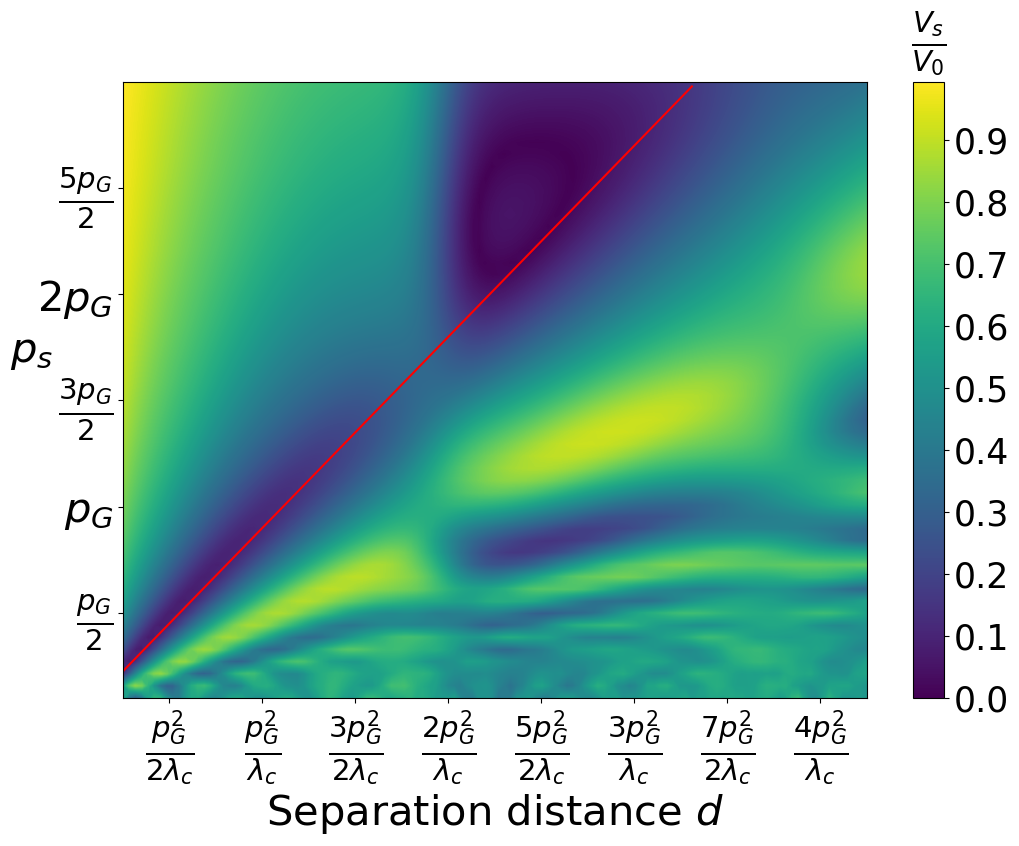

In [52]:
fig, ax = plt.subplots(figsize = (12,8))
# c = ax.imshow(contsamplepgregime/contnosamplepoly,aspect = "auto", extent = [dsample[0]*1e3,dsample[-1]*1e3,ps_vals[0]/p,ps_vals[-1]/p])

c = ax.contourf(contsamplepgregimepoly/contnosamplepoly, levels = 1000, extent = [dsample[0],dsample[-1],ps_vals[0]/p,ps_vals[-1]/p])
cbar = fig.colorbar(c,format = "%.1f")

cbar.ax.tick_params(labelsize = 25)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 30, y = 1.03)


ax.set_yticks(ps_label_locs)
ax.set_yticklabels(ps_labels, fontsize = 20)

ax.set_xticks(d_label_locs)
ax.set_xticklabels(d_labels, fontsize = 25)

ax.plot(dsample[:-28], 2*lam[np.argmax(plam)]*dsample[:-28]*Ls/(p*L) / p, "r")


ax.set_xlabel("Separation distance $d$", fontsize = 30)
ax.set_ylabel(r"$p_s$", fontsize = 30, rotation = "horizontal", y=0.53)
ax.tick_params(labelsize = 30)

fig.savefig("DFIPolychromatic,Ls=3.6.png")

plt.show()
plt.close(fig)

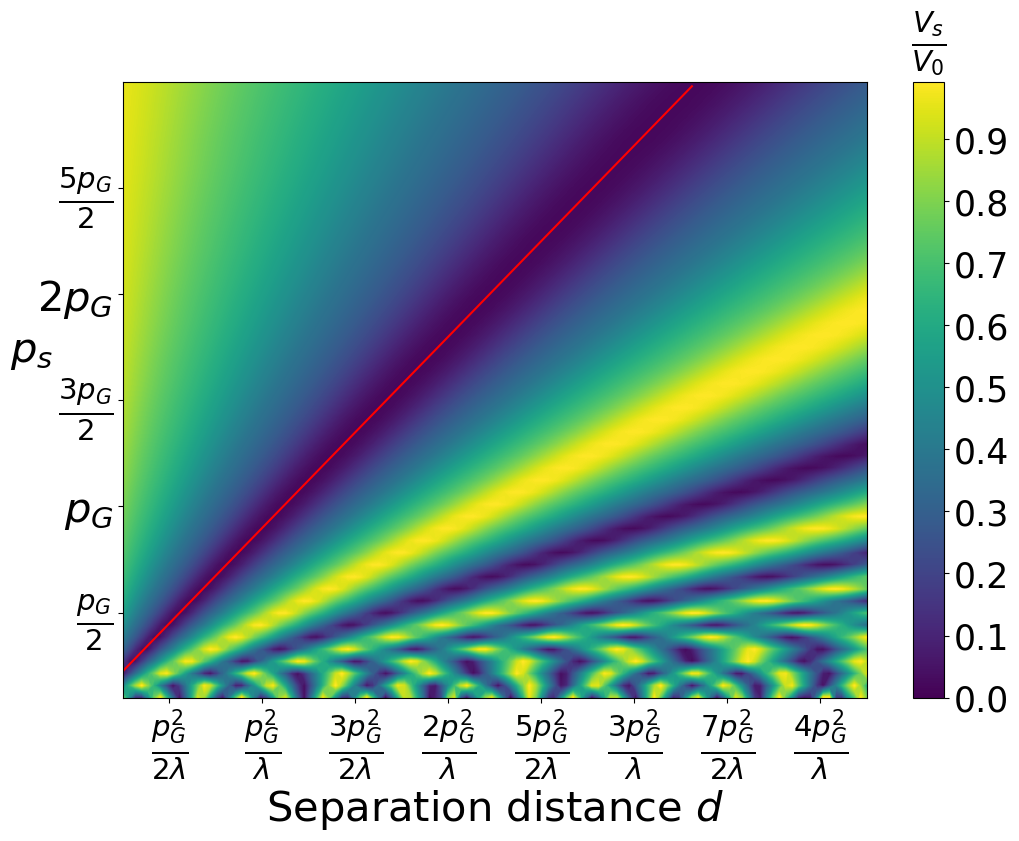

In [72]:
fig, ax = plt.subplots(figsize = (12,8))


cmono_div = contsamplepgregimemono/contnosample5A

mask = cmono_div > 1

cmono_div[mask] = 1



c = ax.contourf(cmono_div, levels = 1000, extent = [dsample[0],dsample[-1],ps_vals[0]/p,ps_vals[-1]/p])
cbar = fig.colorbar(c,format = "%.1f")

cbar.ax.tick_params(labelsize = 25)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 30, y = 1.03)


ax.set_yticks(ps_label_locs)
ax.set_yticklabels(ps_labels, fontsize = 20)

ax.set_xticks(d_label_locs)
ax.set_xticklabels(d_labels, fontsize = 25)

ax.plot(dsample[:-28], 2*lam[np.argmax(plam)]*dsample[:-28]*Ls/(p*L) / p, "r")


ax.set_xlabel("Separation distance $d$", fontsize = 30)
ax.set_ylabel(r"$p_s$", fontsize = 30, rotation = "horizontal", y=0.53)

ax.tick_params(labelsize = 30)

# p_s_line1 = lam[np.argmax(plam)]*2*dsample*Ls/(p*L) / p




fig.savefig("DFIMonochromatic,Ls=3.6.png")

plt.show()
plt.close(fig)

### Phi_3 Grating as Sample Plots

In [82]:
Nbc = 5e28*4.149e-15




lam = np.array([5e-10])
plam = np.array([1])



lam, plam = polyspectrum.copy()


h1 = h2 = np.pi/2 / (Nbc*lam[np.argmax(plam)])

phi1 = phi2 = Nbc*lam * h1 


p = 2e-6
L = 8


mt = 5



xbin = 1e-6
ybin = 1e-6

res = 100e-6




h3_vals = np.arange(0,np.pi + np.pi/6 ,np.pi/6) / (Nbc*lam[np.argmax(plam)])
phi3_vals = Nbc*lam[None,:]*h3_vals[:,None]




In [83]:
t0 = time()

phi3contpoly = []


# phi3contmono = []


for i, phi3 in enumerate(phi3_vals):
    phi3contpoly.append([])
    # phi3contmono.append([])

    # for d in dsample:
    G1sd = {"p":p, "L1": np.array([L1]), "phi": phi1, "mt":mt, "spectrum_spacing": 1}
    G1sd["L2"] = dsample


    G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1}


    G2sd["L2"] = np.array([L]) - Ls - G2sd["L1"]

    p_s = p




    G3sd = {"p":p_s, "L1": G2sd["L2"] + G2sd["L1"], "phi": phi3, "mt":mt, "spectrum_spacing":1}

    G3sd["L2"] = np.array([L]) - G3sd["L1"] 





    simaptsdens = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}





    siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":L,"d": dsample, "mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res  }

    simdens = PGMI(simaptsdens,siminit)

    simdens.propagate_to("G1")
    simdens.propagate_to("G2")
    simdens.propagate_to("G3")
    simdens.generate_after("G3")

    clear_output(wait = True)
    # phi3contmono[-1].append(simdens.contrast)
    phi3contpoly[-1].append(simdens.contrast)



    del simdens
    print((i+1)/len(phi3_vals)*1e2, "% done")


print(time() - t0, "seconds")

100.0 % done
6.882745981216431 seconds


In [84]:
# phi3contmono = np.squeeze(phi3contmono)
phi3contpoly = np.squeeze(phi3contpoly)
# np.save("phi3monocontpiover6steps.npy",phi3monocont)

In [74]:
ps_labels = [r"$\frac{p_G}{2}$", r"$p_G$", r"$\frac{3p_G}{2}$", r"$2p_G$",r"$\frac{5p_G}{2}$"]
ps_label_locs = np.arange(0.5,3,0.5)

d_labels = [r"$\frac{p_G}{2}$", r"$p_G$",r"$\frac{3p_G}{2}$"]
# d_label_locs = np.arange(0.5,4.5,0.5) * p**2 / polyspectrum[0][np.argmax(polyspectrum[1])]
d_label_locs = np.arange(1,4,1) * p*p_s*L/(2*Ls*lam[np.argmax(plam)])

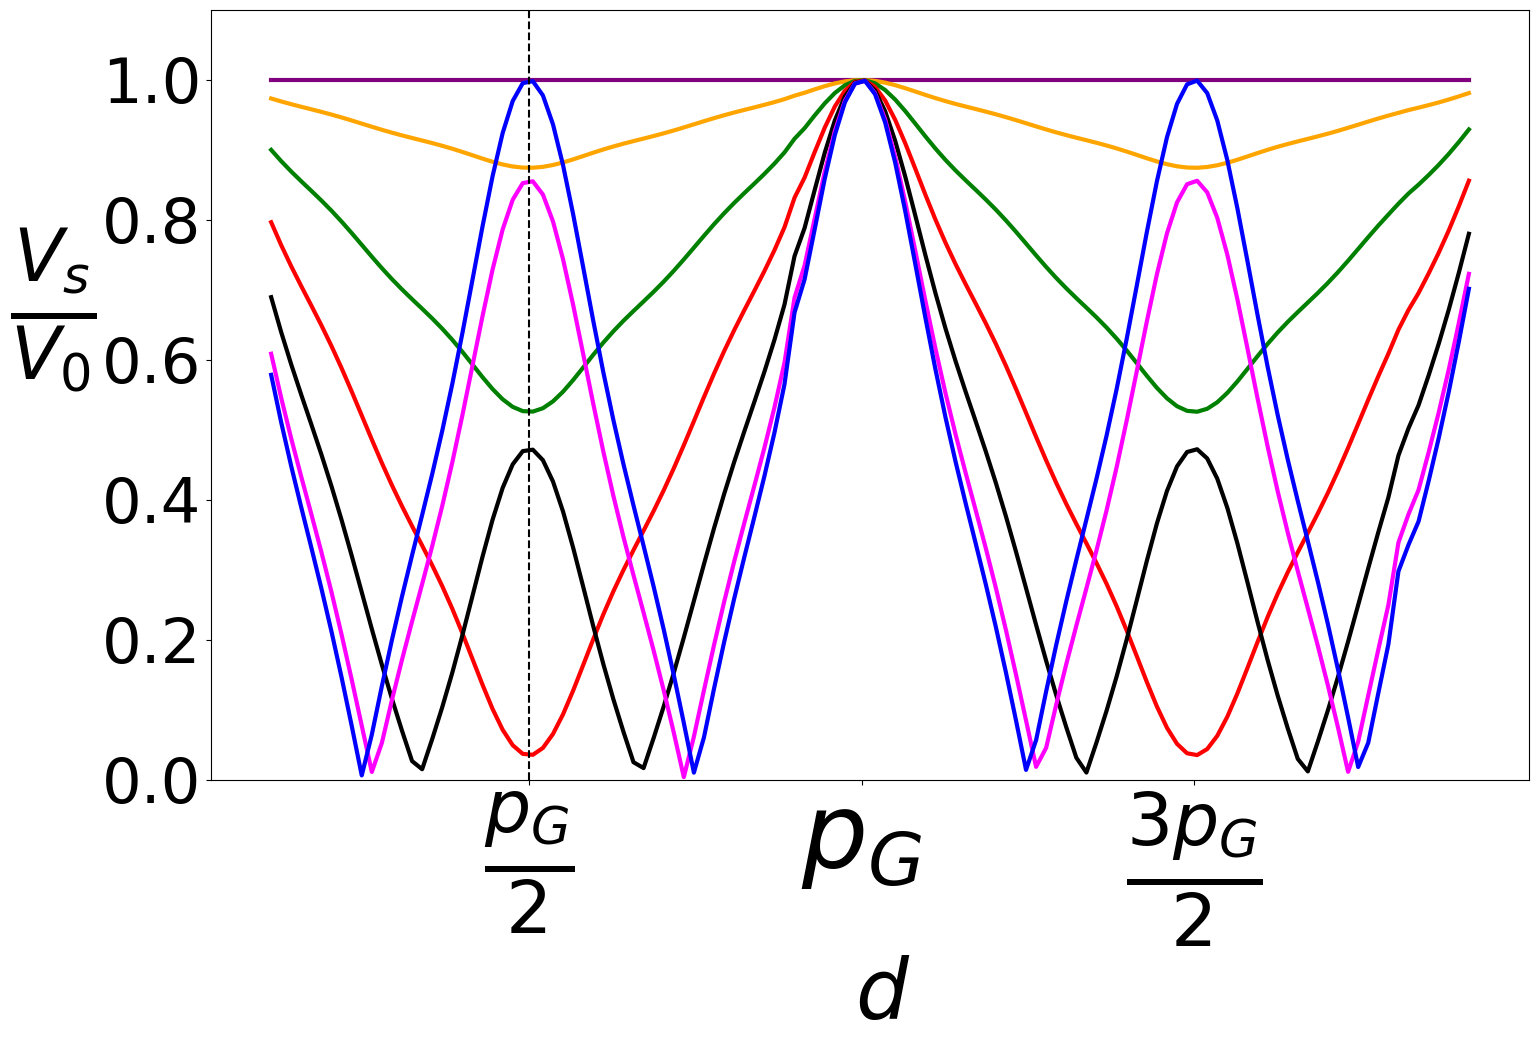

In [75]:
fig, ax1 = plt.subplots(figsize  = (17,10))

ax1.set_prop_cycle(color = ["purple","orange","green","red","black","magenta","blue"])


for i,cont in enumerate(phi3contmono):
    if i == 0:
        ax1.plot(dsample,(cont/(contnosample5A)),lw = 3, label = r"$\phi_s = 0$")
    elif i == 1:
        ax1.plot(dsample,(cont/(contnosample5A)),lw = 3, label = r"$\phi_s = \frac{\pi}{6}$")
    elif i == 6:
        ax1.plot(dsample,(cont/(contnosample5A)),lw = 3, label = r"$\phi_s = \pi$")

    else:
        ax1.plot(dsample,(cont/(contnosample5A)),lw = 3, label = r"$\phi_s = \frac{%d\pi}{6}$" %(i))

        
# ax1.plot(dsample[mask],contnosample5A[mask], label = "No sample")      
# ax1.legend(fontsize= 13)

ax1.set_ylabel(r"$\frac{V_s}{V_0}$", fontsize =75, rotation = "horizontal")
ax1.yaxis.set_label_coords(-0.12, 0.5)
ax1.tick_params(labelsize = 45)


ax1.set_xlabel(" $d$", fontsize = 60)
ax1.set_xticks(d_label_locs)
ax1.set_xticklabels(d_labels, fontsize = 75)

ax1.axvline(p*p_s*L/(2*Ls*lam[np.argmax(plam)]), color = "black", ls = "--")


plt.ylim(0,1.1)

fig.savefig("GratingAsSampleMonochromatic,p_s=p,Ls=3.6.png")

plt.show()
plt.close(fig)

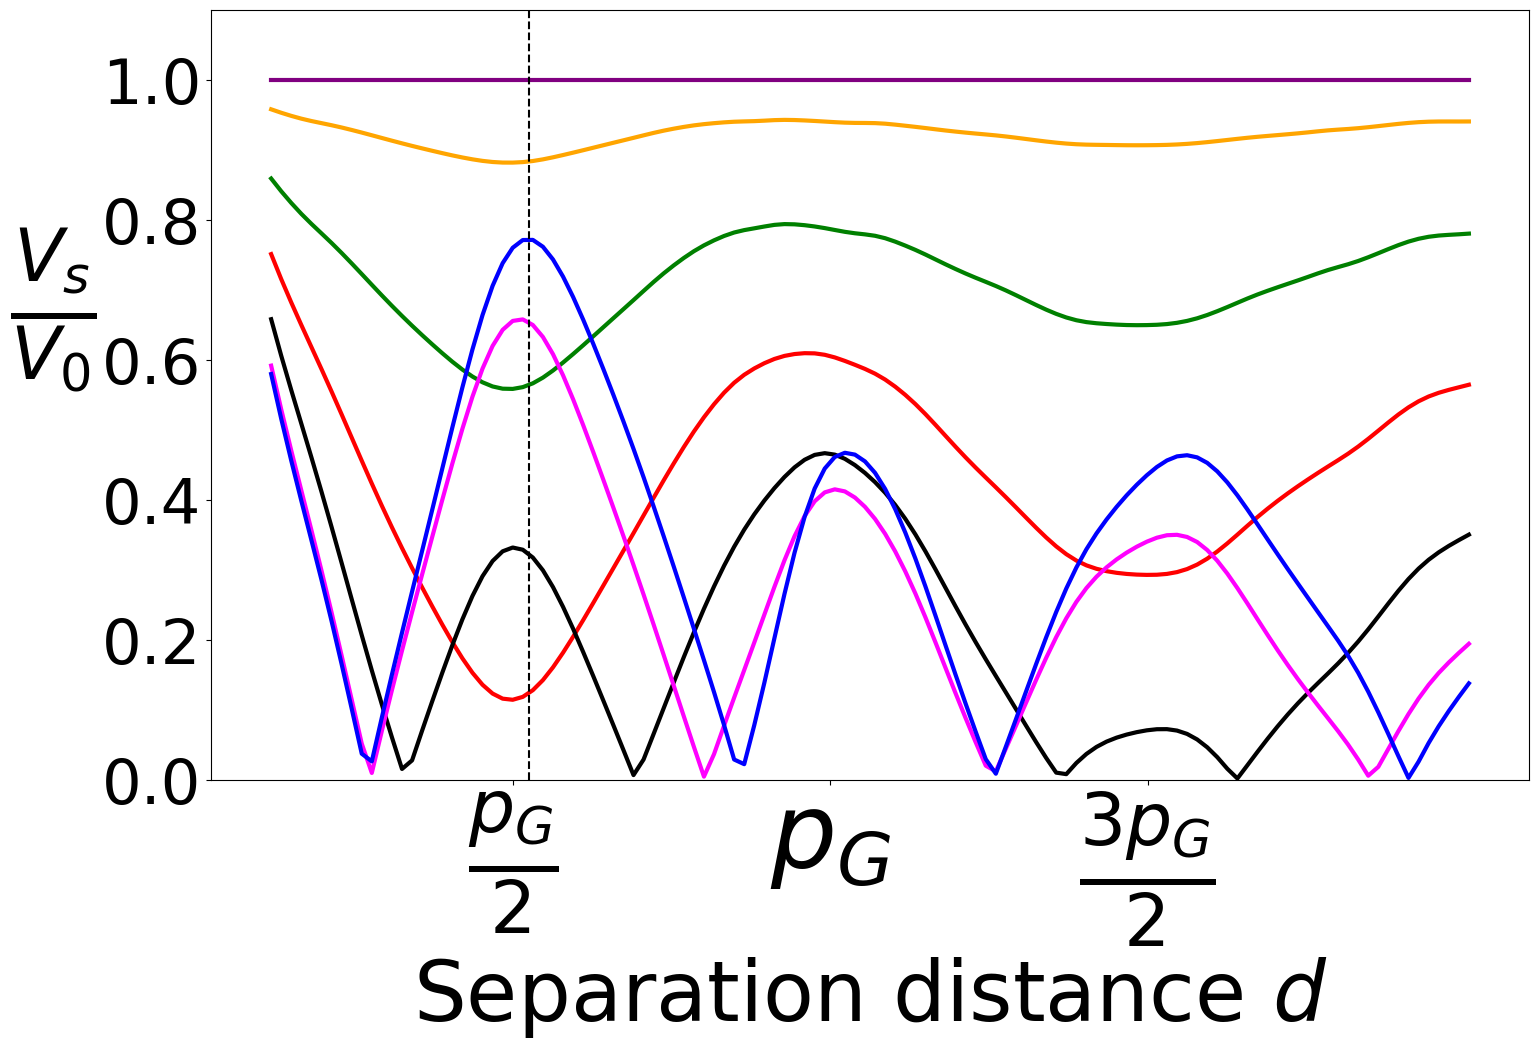

In [86]:
fig, ax1 = plt.subplots(figsize  = (17,10))

ax1.set_prop_cycle(color = ["purple","orange","green","red","black","magenta","blue"])


for i,cont in enumerate(phi3contpoly):
    
    if i == 0:
        ax1.plot(dsample,(cont/(contnosamplepoly)),lw = 3, label = r"$\phi_s = 0$")
    elif i == 1:
        ax1.plot(dsample,(cont/(contnosamplepoly)),lw = 3, label = r"$\phi_s = \frac{\pi}{6}$")
    elif i == 6:
        ax1.plot(dsample,(cont/(contnosamplepoly)),lw = 3, label = r"$\phi_s = \pi$")
    else:
        ax1.plot(dsample,(cont/(contnosamplepoly)),lw = 3, label = r"$\phi_s = \frac{%d\pi}{6}$" %(i))

        
# ax1.plot(dsample[mask],contnosample5A[mask], label = "No sample")      
# ax1.legend(fontsize= 13)

ax1.set_ylabel(r"$\frac{V_s}{V_0}$", fontsize =75, rotation = "horizontal")
ax1.yaxis.set_label_coords(-0.12, 0.5)
ax1.tick_params(labelsize = 45)


ax1.set_xlabel("Separation distance $d$", fontsize = 60)
ax1.set_xticks(d_label_locs)
ax1.set_xticklabels(d_labels, fontsize = 75)

ax1.axvline(p*p_s*L/(2*Ls*lam[np.argmax(plam)]), color = "black", ls = "--")

fig.savefig("GratingAsSamplePolychromatic,p_s=p,Ls=3.6.png")

plt.ylim(0,1.1)


plt.show()
plt.close(fig)

### DFI Data to verify

In [320]:
p3data = 700e-9

h3data = 4e-6

Nbc = 5e28*4.149e-15

sgpdata = np.array([400,700,900,2000])*1e-6
Ldata = 6
p1data = p2data = 2.1e-6
ddata = Ldata * p1data / sgpdata
h1data = 25e-6
L1data = 3
resdata = 100e-6


xbin = 1e-6
ybin = 1e-6
mt = 5

Lsdata = pd.read_excel("/Users/macprorac2/Documents/Gabriel Dima's Group/Data/DFI/SiGrating_xidata_2.xlsx",\
        usecols=[5],skiprows=np.arange(22,85,1)).to_numpy().squeeze()*1e-3

Lssim = np.linspace(Lsdata[0], Lsdata[-1], 51)
# gratings placed midway

polyspectrum = pd.read_excel("/Users/macprorac2/Documents/Gabriel Dima's Group/Data/DFI/CG-1D_Flux_measured_with_Chopper_2010.xlsx",\
        sheet_name=-1, skiprows=(0,), usecols = (0,1)).to_numpy()[:-1].T
polyspectrum[0]*=1e-10

lam, plam = polyspectrum.copy()

phi1data = phi2data = Nbc*lam*h1data

# dsim = np.linspace(0.1, ,81) * p1data**2/lam[np.argmax(plam)]
dsim = np.linspace(0.001,0.05,41) 

p_ssim = np.linspace(p1data/8, 2*p1data, 31)



In [259]:
ddata*1e3

array([31.5, 18. , 14. ,  6.3])

In [260]:
G1sd = {"p":p1data, "L1": np.array([L1data]), "phi": phi1data, "mt":mt, "spectrum_spacing": 1}
G1sd["L2"] = dsim


G2sd = {"p":p2data, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2data, "mt":mt, "spectrum_spacing": 1}


G2sd["L2"] = np.array([Ldata])  - G2sd["L1"]


# print(G1sd["L1"],G1sd["L2"],G2sd["L1"],G2sd["L2"])



simaptsDFI = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}





siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": dsim, "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
           "convmode" : "valid", "resx": resdata, "resy":resdata, "source_period":sgpdata[1], "duty_cycle":0.3  }
# siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": dsim, "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
#            "convmode" : "valid", "resx": resdata, "resy":resdata, "slitx":sgpdata[1]/2 }

simDFI = PGMI(simaptsDFI,siminit)

simDFI.propagate_to("G1")
simDFI.propagate_to("G2")
simDFI.generate_after("G2")


In [261]:
contempty700 = simDFI.contrast
print(contempty700.shape)

(41,)


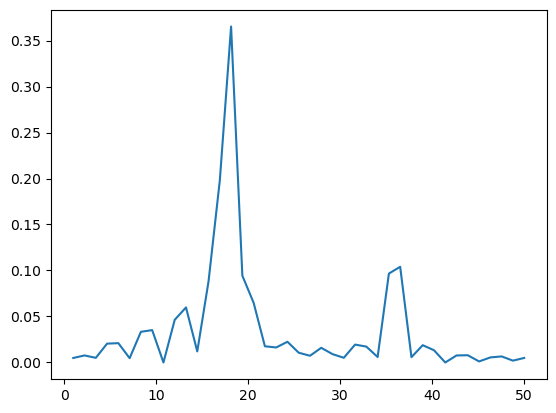

In [262]:
plt.plot(dsim*1e3,contempty700)

In [263]:
cont700 = []
for i, p_s in enumerate(p_ssim):
    G1sd = {"p":p1data, "L1": np.array([L1data]), "phi": phi1data, "mt":mt, "spectrum_spacing": 1}
    G1sd["L2"] = dsim


    G2sd = {"p":p2data, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2data, "mt":mt, "spectrum_spacing": 1}

    G2sd["L2"] = np.array([Ldata])  - Lsdata[0] - G2sd["L1"]

    
    G3sd = {"p":p_s, "L1": G2sd["L2"] + G2sd["L1"], "phi": phi3data, "mt":mt, "spectrum_spacing":1}

    G3sd["L2"] = np.array([Ldata])  - G3sd["L1"]





    simaptsDFI = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}





    siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": dsim, "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "resx": resdata, "resy":resdata, "source_period":sgpdata[1], "duty_cycle":0.3  }

    # siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": dsim, "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
    #            "convmode" : "valid", "resx": resdata, "resy":resdata, "slitx":sgpdata[1]/2,}
    simDFI = PGMI(simaptsDFI,siminit)

    simDFI.propagate_to("G1")
    simDFI.propagate_to("G2")
    simDFI.propagate_to("G3")
    simDFI.generate_after("G3")
    cont700.append(simDFI.contrast)
    clear_output(wait=True)
    print(i)
    


30


In [264]:
cont700 = np.array(cont700)
cont700.shape

(31, 41)

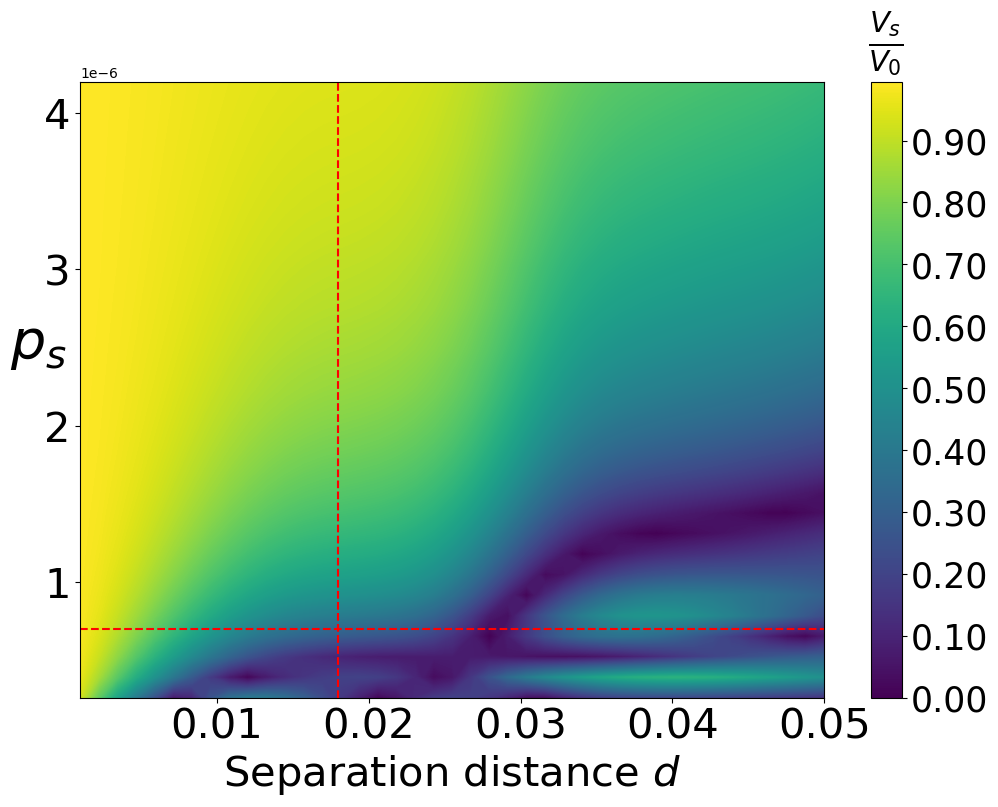

In [265]:
fig, ax = plt.subplots(figsize = (12,8))


csimdiv = cont700/contempty700

# mask = csimdiv > 1

# csimdiv[mask] = 1



c = ax.contourf(csimdiv, levels = 1000, extent = [dsim[0],dsim[-1],p_ssim[0],p_ssim[-1]])
cbar = fig.colorbar(c,format = "%.2f")

cbar.ax.tick_params(labelsize = 25)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 30, y = 1.03)


# ax.set_yticks(ps_label_locs)
# ax.set_yticklabels(ps_labels, fontsize = 20)

# ax.set_xticks(d_label_locs)
# ax.set_xticklabels(d_labels, fontsize = 25)



ax.set_xlabel("Separation distance $d$", fontsize = 30)
ax.set_ylabel(r"$p_s$", fontsize = 40, rotation = "horizontal", y=0.53)

ax.tick_params(labelsize = 30)

# p_s_line1 = lam[np.argmax(plam)]*2*dsample*Ls/(p*L) / p

ax.axvline(ddata[1], color = "r", ls = "--")
ax.axhline(p3data, color = "r", ls = "--")


# fig.savefig("DFIMonochromatic,Ls=3.6.png")

plt.show()
plt.close(fig)

In [205]:
ddata

array([0.0315, 0.018 , 0.014 , 0.0063])

In [321]:
contempty = []

for i, sgp in enumerate(sgpdata):
    G1sd = {"p":p1data, "L1": np.array([L1data]), "phi": phi1data, "mt":mt, "spectrum_spacing": 1}
    G1sd["L2"] = ddata[i]

    
    G2sd = {"p":p2data, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2data, "mt":mt, "spectrum_spacing": 1}


    G2sd["L2"] = np.array([Ldata])  - G2sd["L1"]


    # print(G1sd["L1"],G1sd["L2"],G2sd["L1"],G2sd["L2"])



    simaptsDFI = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}





    siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": ddata[i], "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "resx": resdata, "resy":resdata, "source_period":sgp, "duty_cycle":0.3  }
    # siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": ddata[i], "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
    #            "convmode" : "valid", "resx": resdata, "resy":resdata, "slitx":sgp/2,   }

    simDFI = PGMI(simaptsDFI,siminit)

    simDFI.propagate_to("G1")
    simDFI.propagate_to("G2")
    simDFI.generate_after("G2")

    contempty.append(simDFI.contrast)

In [322]:
t0 = time()

contDFI = []

for i, sgp in enumerate(sgpdata):

    
    G1sd = {"p":p1data, "L1": np.array([L1data]), "phi": phi1data, "mt":mt, "spectrum_spacing": 1}
    G1sd["L2"] = ddata[i]


    G2sd = {"p":p2data, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2data, "mt":mt, "spectrum_spacing": 1}


    G2sd["L2"] = np.array([Ldata]) - Lssim - G2sd["L1"]

    phi3data = Nbc*lam*h3data


    
    G3sd = {"p":p3data, "L1": G2sd["L2"] + G2sd["L1"], "phi": phi3data, "mt":mt, "spectrum_spacing":1}

    G3sd["L2"] = np.array([Ldata]) - G3sd["L1"] 

    

    # print(G1sd["L1"],G1sd["L2"],G2sd["L1"],G2sd["L2"], G3sd["L1"],G3sd["L2"])



    simaptsDFI = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}





    siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": ddata[i], "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "resx": resdata, "resy":resdata, "source_period":sgp, "duty_cycle":0.3  }
    # siminit = {"lam":lam, "plam":plam, "sum_lam":True, "L":Ldata,"d": ddata[i], "mt":mt, "p" :p1data,"xbin":xbin,"ybin":ybin ,\
    #            "convmode" : "valid", "resx": resdata, "resy":resdata, "slitx": sgp/2  }

    simDFI = PGMI(simaptsDFI,siminit)
    
    plt.plot(simDFI.source_grating)
    plt.show()
    
    simDFI.propagate_to("G1")
    simDFI.propagate_to("G2")
    simDFI.propagate_to("G3")
    simDFI.generate_after("G3")

    clear_output(wait = True)
    print((i+1)/len(sgpdata)*1e2, "% done")

    

    contDFI.append(simDFI.contrast)
    

    
print(time() - t0, "seconds")



100.0 % done
83.23164105415344 seconds


In [323]:
contempty = assert_ndarr(contempty)
contDFI = assert_ndarr(contDFI)

In [324]:
contDFI.shape

(4, 51)

In [325]:
sgplabels = [400,700,900,2000]

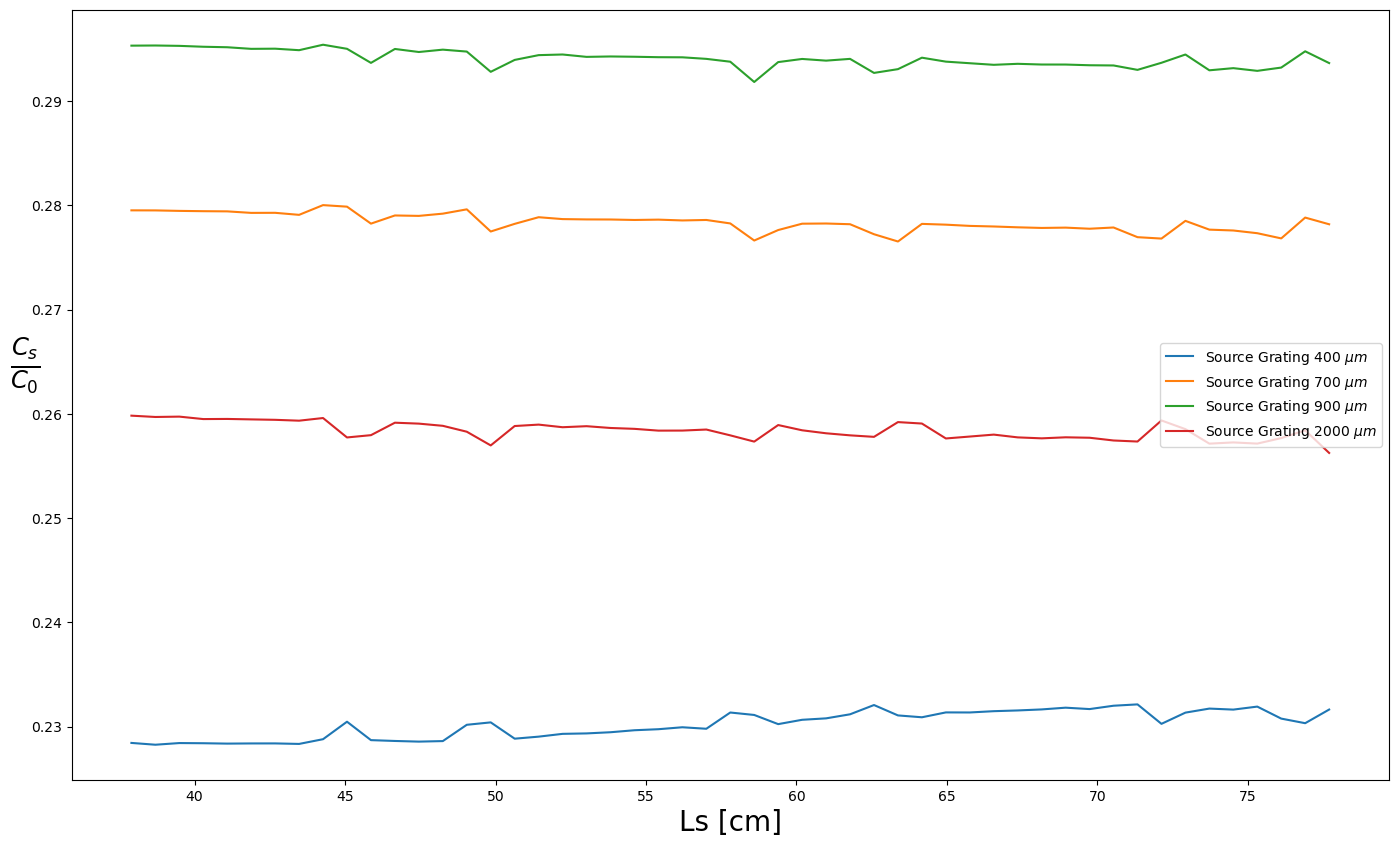

In [326]:
fig, ax1 = plt.subplots(figsize  = (17,10))

for i, sgp in enumerate(sgpdata):

    ax1.plot(Lssim*1e2,(contDFI)[i],label = r"Source Grating %d $\mu m$" % sgplabels[i])


ax1.set_xlabel("Ls [cm]", fontsize = 20)
ax1.set_ylabel(r"$\frac{C_s}{C_0}$", rotation = "horizontal", fontsize = 25)
ax1.legend()

plt.show()
plt.close(fig)